Tabela de CDI e Selic - Data mais recente: 08/12/2023

      Data Reuniao  Mediana   CDI        ∆
13/12/2023 R8/2023    11.75 11.65   0.000%
31/01/2024 R1/2024    11.25 11.15 (0.500%)
20/03/2024 R2/2024    10.75 10.65 (0.500%)
08/05/2024 R3/2024    10.25 10.15 (0.500%)
19/06/2024 R4/2024     9.75  9.65 (0.500%)
31/07/2024 R5/2024     9.50  9.40 (0.250%)
18/09/2024 R6/2024     9.50  9.40   0.000%
06/11/2024 R7/2024     9.50  9.40   0.000%
11/12/2024 R8/2024     9.25  9.15 (0.250%)

CDI Acumulado até 11/12/2024: 15.09%


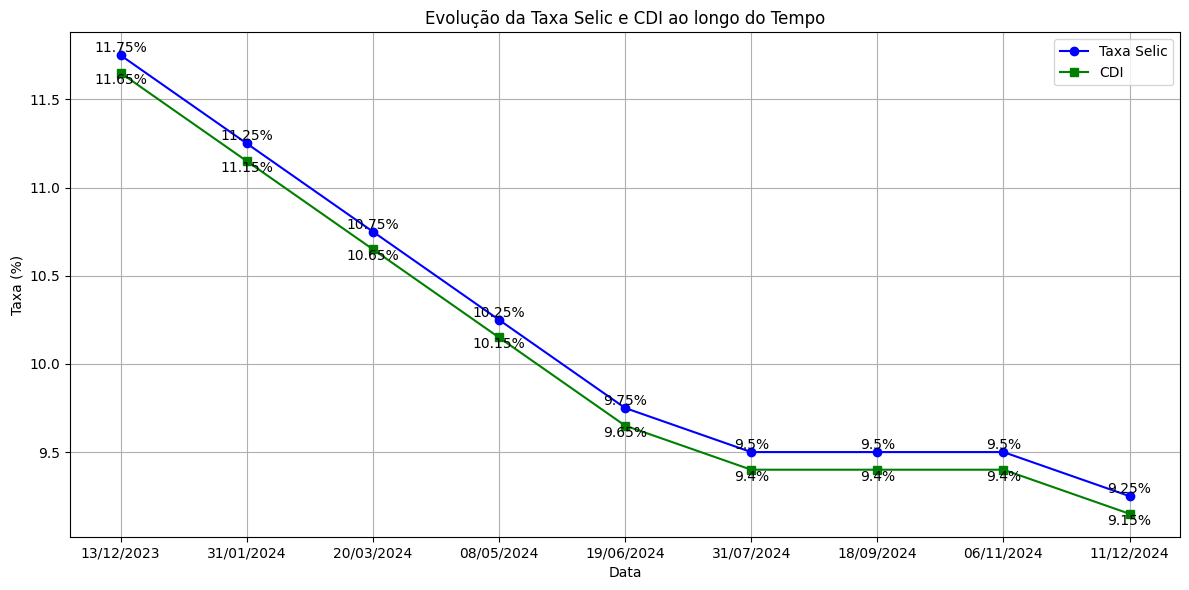

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files


# Obter os dados
url = "https://olinda.bcb.gov.br/olinda/servico/Expectativas/versao/v1/odata/ExpectativasMercadoSelic"
response = requests.get(url)
data = response.json()

# Criar o DataFrame
df = pd.DataFrame(data['value'])

# Converter a coluna 'Data' para o formato de data
df['Data'] = pd.to_datetime(df['Data'])

# Encontrar a data mais recente
data_mais_recente = df['Data'].max()

# Filtrar o DataFrame para mostrar apenas as linhas com a data mais recente
df_mais_recente = df[df['Data'] == data_mais_recente].copy()

# Criar uma coluna auxiliar para ordenação correta
df_mais_recente['AnoReuniao'] = df_mais_recente['Reuniao'].apply(lambda x: int(x.split('/')[1] + x.split('/')[0][1:]))

# Filtrar para as reuniões de 'R8/2023' até 'R8/2024', ordenadas corretamente
df_filtrado = df_mais_recente[(df_mais_recente['AnoReuniao'] >= 20238) & (df_mais_recente['AnoReuniao'] <= 20248)].sort_values('AnoReuniao', ascending=False)

# Agrupar por 'Reuniao' e manter a linha com a Mediana mais alta
df_agrupado = df_filtrado.groupby('Reuniao').apply(lambda x: x.nlargest(1, 'Mediana')).reset_index(drop=True)

# Calcular o CDI como 0,1% abaixo da Mediana
df_agrupado['CDI'] = df_agrupado['Mediana'] - 0.1

# Mapeamento das reuniões para as datas
mapeamento_datas = {
    'R8/2023': '13/12/2023',
    'R1/2024': '31/01/2024',
    'R2/2024': '20/03/2024',
    'R3/2024': '08/05/2024',
    'R4/2024': '19/06/2024',
    'R5/2024': '31/07/2024',
    'R6/2024': '18/09/2024',
    'R7/2024': '06/11/2024',
    'R8/2024': '11/12/2024'
}

# Adicionar a coluna de datas
df_agrupado['Data'] = df_agrupado['Reuniao'].map(mapeamento_datas)

# Converter a coluna 'Data' para o formato datetime e ordenar
df_agrupado['Data'] = pd.to_datetime(df_agrupado['Data'], dayfirst=True)
df_ordenado = df_agrupado.sort_values('Data')

# Calcular a variação (∆) e formatar
df_ordenado['∆'] = df_ordenado['Mediana'].diff().fillna(0)
df_ordenado['∆'] = df_ordenado['∆'].apply(lambda x: f"({abs(x):.3f}%)"
                                            if x < 0 else f"{x:.3f}%")

# Organizar as colunas
df_final = df_ordenado[['Data', 'Reuniao', 'Mediana', 'CDI', '∆']].copy()

# Converter a coluna 'Data' de volta para string no formato desejado
df_final['Data'] = df_final['Data'].dt.strftime('%d/%m/%Y')

# Título da tabela com uma linha em branco após
titulo_tabela = f"Tabela de CDI e Selic - Data mais recente: {data_mais_recente.strftime('%d/%m/%Y')}\n"

# Converter o DataFrame para uma string sem índices
tabela_formatada = df_final.to_string(index=False)

# Exibir o título e a tabela formatada
print(titulo_tabela)
print(tabela_formatada)

# Calcular o número de dias entre as reuniões
df_ordenado['Dias'] = (df_ordenado['Data'].shift(-1) - df_ordenado['Data']).fillna(pd.Timedelta(days=0)).dt.days

# Calcular o fator de acumulação do CDI
df_ordenado['Fator_CDI'] = (1 + df_ordenado['CDI'] / 100) ** (df_ordenado['Dias'] / 252)

# Calcular o CDI acumulado
cdi_acumulado = df_ordenado['Fator_CDI'].cumprod().iloc[-1] - 1

# Convertendo o DataFrame para uma string sem índices para exibição
tabela_formatada = df_ordenado.to_string(index=False)

# Título da tabela com uma linha em branco após
titulo_tabela = f"Tabela de CDI e Selic - Data mais recente: {data_mais_recente.strftime('%d/%m/%Y')}\n"

# Exibir o título e a tabela formatada
print(f"\nCDI Acumulado até {df_ordenado['Data'].iloc[-1].strftime('%d/%m/%Y')}: {cdi_acumulado * 100:.2f}%")

# Criar o gráfico
plt.figure(figsize=(12, 6))

# Plotar a taxa Selic
plt.plot(df_final['Data'], df_final['Mediana'], '-o', label='Taxa Selic', color='blue')

# Plotar o CDI
plt.plot(df_final['Data'], df_final['CDI'], '-s', label='CDI', color='green')

# Configurar título e rótulos
plt.title('Evolução da Taxa Selic e CDI ao longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Taxa (%)')
plt.grid(True)
plt.legend()

# Adicionando rótulos
for i in range(len(df_final)):
    # Anotação para Taxa Selic
    plt.text(df_final['Data'].iloc[i], df_final['Mediana'].iloc[i], f"{df_final['Mediana'].iloc[i]}%",
             ha='center', va='bottom')

    # Anotação para CDI
    plt.text(df_final['Data'].iloc[i], df_final['CDI'].iloc[i], f"{df_final['CDI'].iloc[i]}%",
             ha='center', va='top')

# Ajuste final para evitar sobreposição
plt.tight_layout()

# Mostrar o gráfico
plt.show()

# Salvando os dados em um arquivo Excel
excel_filename = "Relatorio_Selic_CDI.xlsx"
with pd.ExcelWriter(excel_filename) as writer:
    df_final.to_excel(writer, sheet_name='Resumo', index=False)
    df_ordenado.to_excel(writer, sheet_name='Dados Detalhados', index=False)

# Iniciando o download do arquivo
files.download(excel_filename)